In [1]:
import numpy as np
import pandas as pd

from scipy.ndimage import uniform_filter1d
from scipy.optimize import curve_fit
from scipy import integrate

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
def conv_energy(x):
    energy=0.000002*x**2 - 0.0003 * x + .1265
    return energy

In [3]:
def rmv_mean(df_camera,lastpoints):
    x=np.linspace(0,len(df_camera.columns)-1,len(df_camera.columns))
    #get the coeficients for each shhot
    coef=df_camera.apply(lambda row: np.polyfit(x[-lastpoints:], row[-lastpoints:], 1),axis=1, result_type='expand').to_numpy()
    m=coef[:,0]
    b=coef[:,1]

    #build the aray with the fitting for every shot
    fit=[]
    for i in range(0,len(m)):
        fit.append(m[i]*x+b[i])
    df_fitting=pd.DataFrame(fit)

    #df_adjusted=df_camera-df_fitting
    return df_camera-df_fitting

In [4]:
filename_cam='datasets/galadriel_dataset_24_09_06_cam.npy'

In [5]:
#read the data
with open(filename_cam,'rb') as f:
    camera_list=np.load(f)
    
#get the background array
background=camera_list[0]
camera_list=camera_list[1:]
#substract the background
camera_clean=camera_list.astype(np.int16)-background.astype(np.int16)
camera_clean[camera_clean<0]=0 #remove negative values

In [6]:
print(camera_clean[0])
print(background)
#print(camera_list[0].astype(np.int16)-background.astype(np.int16))

[[0 0 0 ... 0 6 0]
 [1 4 0 ... 0 0 7]
 [0 0 0 ... 9 0 6]
 ...
 [4 2 1 ... 4 2 0]
 [5 0 2 ... 0 0 0]
 [0 2 0 ... 4 0 0]]
[[100 123 113 ... 115 101 133]
 [197 197 202 ... 211 184 220]
 [206 221 205 ... 211 209 223]
 ...
 [187 197 191 ... 200 203 212]
 [205 204 208 ... 205 193 225]
 [214 197 203 ... 200 190 212]]


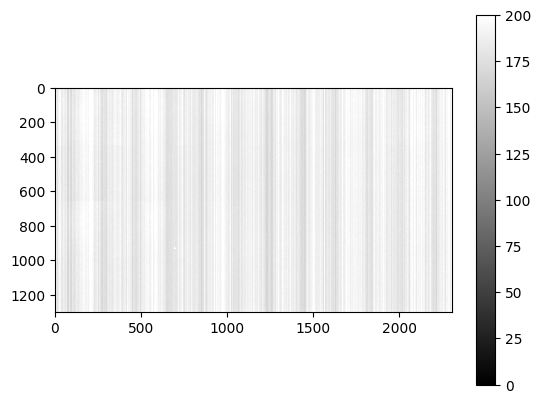

In [7]:
plt.imshow(background,cmap='gray',vmin=0,vmax=200)
plt.colorbar(orientation='vertical')

(1200.0, 0.0)

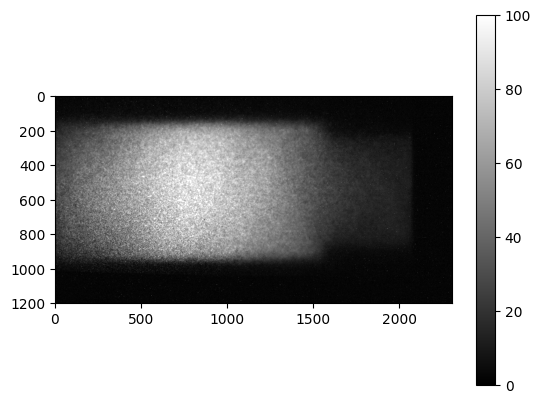

In [8]:
plt.imshow(camera_clean[1],cmap='gray',vmin=0,vmax=100)
plt.colorbar(orientation='vertical')
plt.ylim(1200,0)

In [9]:
#the counts outside the range depend on the temperature (so time in the experiment)

In [10]:
temp_ref_area=camera_clean[4][1050:1200,:]
ref_area_mean=np.mean(temp_ref_area)
print('Average count in the reference area:',ref_area_mean)

Average count in the reference area: 2.1753530092592595


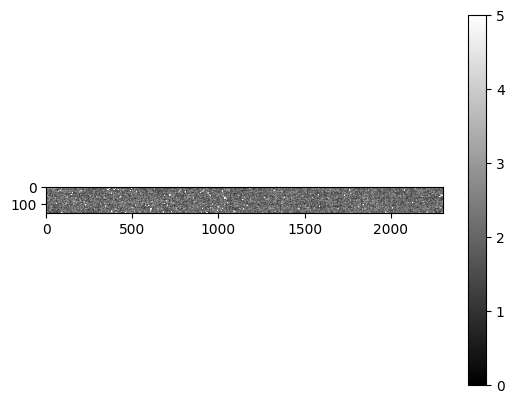

In [11]:
#Note that the plot doesnt show the actual y axis from e-spec
plt.imshow(temp_ref_area,cmap='gray',vmin=0,vmax=5)
plt.colorbar(orientation='vertical')

In [12]:
test=np.array([5,7,8,1])
print(test-1)

[4 6 7 0]


# Analysis of the electron spectrum for ALL shots

In [13]:
filename='datasets/galadriel_dataset_24_09_06_phys.h5'

In [14]:
df_input=pd.read_hdf(filename,'df_input')
df_camera=pd.read_hdf(filename,'df_camera')


#get the arrays and print them
print('Input DF')
print(df_input)

print('----')
print('Camera 1D')
print(df_camera)

Input DF
      shot number   order2   order3     order4  Laser Energy
0          129950  34900.0 -17000.0 -4600000.0      0.002349
1          129951  35300.0   4000.0 -4300000.0      0.002186
2          129952  35300.0   4000.0 -4300000.0      0.002333
3          129953  35300.0   4000.0 -4300000.0      0.002284
4          129954  35300.0   4000.0 -4300000.0      0.002234
...           ...      ...      ...        ...           ...
3060       133018  35100.0  10000.0 -3700000.0      0.002270
3061       133019  35100.0  10000.0 -3700000.0      0.002356
3062       133020  35100.0  10000.0 -3700000.0      0.002295
3063       133021  35100.0  10000.0 -3700000.0      0.002283
3064       133022  35100.0  10000.0 -3700000.0      0.002278

[3065 rows x 5 columns]
----
Camera 1D
           0          1          2          3          4          5     \
0      4.380935   6.480935   6.580935   4.200935   6.420935   6.420935   
1     20.815341  20.695341  21.935341  21.195341  25.155341  24.135341 

In [15]:
df_input.describe()

,shot number,order2,order3,order4,Laser Energy
count,3065.000000,3065.000000,3065.000000,3.065000e+03,3065.000000
mean,131484.816966,35150.179445,5514.192496,-4.150147e+06,0.002853
std,887.389297,170.797547,13832.946262,3.354211e+05,0.000831
min,129950.000000,34900.000000,-17000.000000,-4.600000e+06,0.001522
25%,130716.000000,35000.000000,-5000.000000,-4.600000e+06,0.002213
50%,131484.000000,35200.000000,7000.000000,-4.000000e+06,0.002581
75%,132253.000000,35300.000000,19000.000000,-4.000000e+06,0.003402
max,133022.000000,35400.000000,28000.000000,-3.700000e+06,0.005133


Text(0.5, 0, 'Pixels')

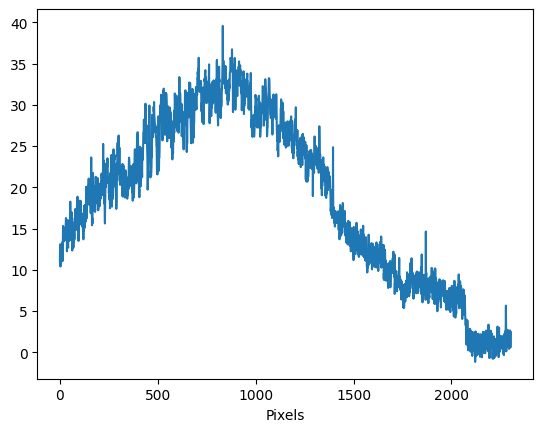

In [16]:
e_dist=df_camera.loc[200]
x=np.linspace(0,len(df_camera.columns)-1,len(df_camera.columns))
MeV = 0.000002*x**2 - 0.0003 * x + .1265
#plt.plot(MeV,e_dist)
#plt.xlabel('Energy(MeV)')
#plt.show()

plt.plot(x,e_dist)
plt.xlabel('Pixels')

### Temperature analysis

In [17]:
cam_sum=df_camera.sum(axis=1)/len(df_camera.columns)

Text(0, 0.5, 'Number of count per pixel')

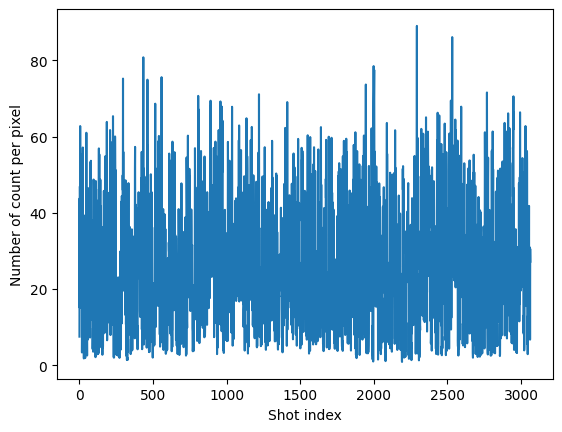

In [18]:
x=np.linspace(0,len(cam_sum)-1,len(cam_sum))
#p1,p2,b = np.polyfit(x, cam_sum, 2)
#print(p1,p2,b)
#fitting=p1*x**2+p2*x+b

plt.plot(cam_sum)
#plt.plot(fitting)
plt.xlabel('Shot index')
plt.ylabel('Number of count per pixel')

## SMOOTH THE DATA and drop last values

In [19]:
#smooth the whole camera dataframe
df_camera_smooth=df_camera.apply(uniform_filter1d,axis=1,size=10,result_type='broadcast')

df_camera_smooth=df_camera_smooth.iloc[:,0:2000].copy()

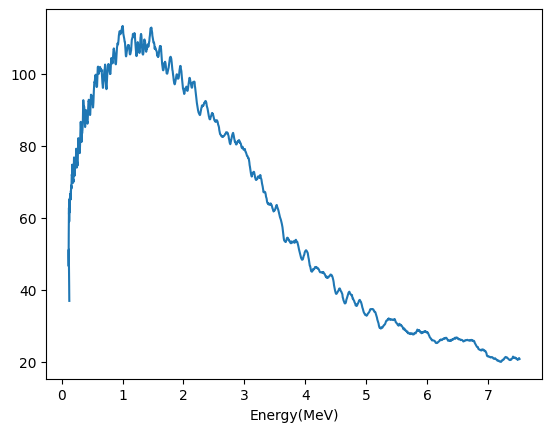

Text(0.5, 0, 'Pixels')

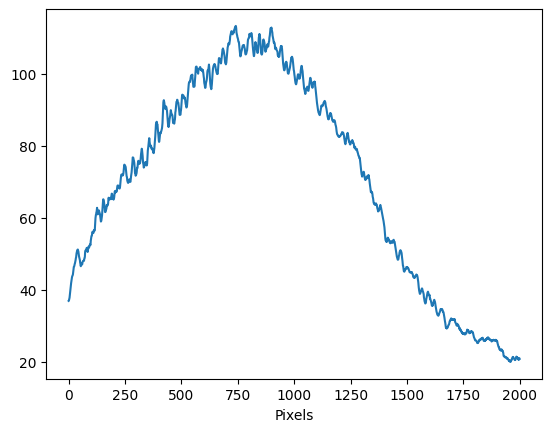

In [20]:
e_dist=df_camera_smooth.loc[208]
x=np.linspace(0,len(df_camera_smooth.columns)-1,len(df_camera_smooth.columns))
MeV = 0.000002*x**2 - 0.0003 * x + .1265
plt.plot(MeV,e_dist)
plt.xlabel('Energy(MeV)')
plt.show()

plt.plot(x,e_dist)
plt.xlabel('Pixels')

## Remove the avg

In [21]:
lastpoints=300
df_camera_adjusted=rmv_mean(df_camera_smooth,lastpoints)

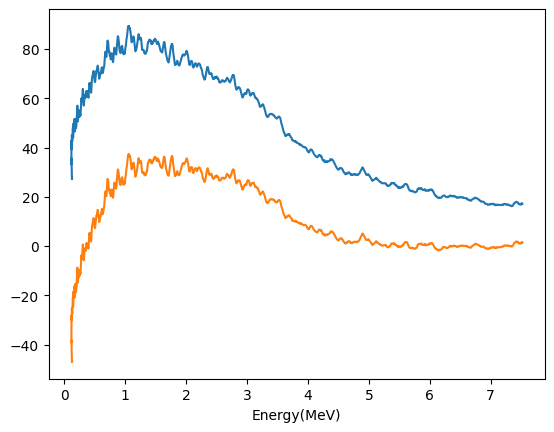

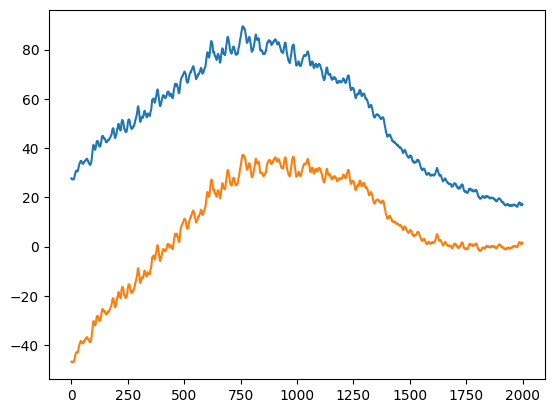

In [22]:
shot_index=2450
#fitting=coef.iloc[shot_index][0]*x+coef.iloc[shot_index][1]
e_dist=df_camera_smooth.loc[shot_index]
e_dist_adj=df_camera_adjusted.loc[shot_index]

MeV = 0.000002*x**2 - 0.0003 * x + .1265
plt.plot(MeV,e_dist)
plt.plot(MeV,e_dist_adj)
plt.xlabel('Energy(MeV)')
plt.show()

plt.plot(x,e_dist)
#plt.plot(fit[shot_index])
plt.plot(x,e_dist_adj)

### Look for the maximum

In [23]:
## Fit a curve to given (x,y) data
def fitting(x,y,p0):
    popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
    return popt

#define the curve to fit
def func(t,c0, c1,c2): 
    #return c0*np.log(c1)+c2*t
    #return c0*x**2+c1*x+c2
    return c0*np.exp(-((t-c1)**2)/(2*c2*c2))

#Look for max location using the fitting function (around the maximum value)
#Returns the 'pixel' location of the maximum
def find_max(e_dist):
    try:
        #x=np.linspace(0,len(e_dist)-1,len(e_dist))
        #redefine a shorter range around the max
        e_zoom=e_dist[int(0.5*np.argmax(e_dist)):int(1.5*np.argmax(e_dist))]
        x_zoom=np.linspace(int(0.5*np.argmax(e_dist)),int(1.5*np.argmax(e_dist))-1,len(e_zoom))
        #p0=[np.max(e_dist),500,1]#initial guess
        p0=[np.max(e_dist),np.argmax(e_dist),1]#initial guess
        popt=fitting(x_zoom,e_zoom,p0)
    except:
        print('Error in the find max')
        popt=[0,0,0]
    if(popt[1]>len(e_dist) or popt[1]<0):
        return 0 #could'nt find the max with this method
    else:
        return popt[1]
        
#Look for max location using the fitting function
#Returns the 'pixel' location of the maximum
def find_max_old(e_dist):
    try:
        #print(e_dist)
        x=np.linspace(0,len(e_dist)-1,len(e_dist))
        #print(len(e_dist)-1,e_dist[1])
        p0=[np.max(e_dist),500,1]#initial guess
        popt=fitting(x,e_dist,p0)
    except:
        print('Error in the find max')
        popt=[0,0,0]
    if(popt[1]>len(e_dist) or popt[1]<0):
        return 0 #could'nt find the max with this method
    else:
        return popt[1]

917.9772368472411
[20.88946027696614, 1, 1]
[17.63170419  1.72729591  1.25311742]


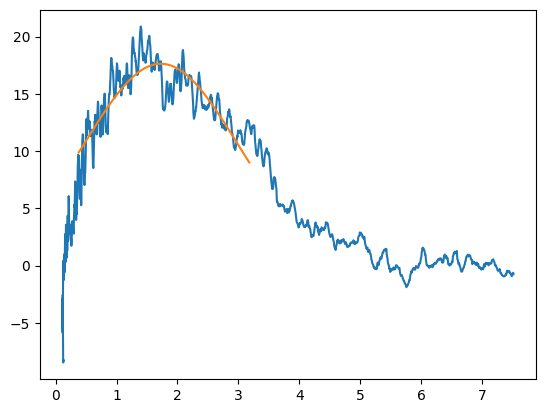

In [24]:
e_dist_adj=df_camera_adjusted.loc[200]
#x=np.linspace(0,len(df_camera_adjusted.columns)-1,len(df_camera_adjusted.columns))
x=np.linspace(0,len(e_dist_adj)-1,len(e_dist_adj))
x_ene=conv_energy(x)

e_zoom=e_dist_adj[int(0.5*np.argmax(e_dist_adj)):int(1.5*np.argmax(e_dist_adj))]
x_zoom=np.linspace(int(0.5*np.argmax(e_dist_adj)),int(1.5*np.argmax(e_dist_adj))-1,len(e_zoom))

print(find_max(e_dist_adj))

#fitting in the energy domain
#around the peak
p0=[np.max(e_dist_adj),1,1]#initial guess
print(p0)

x_ene_zoom=conv_energy(x_zoom)

popt=fitting(x_ene_zoom,e_zoom,p0)
print(popt)
y_fit=func(x_ene_zoom,popt[0],popt[1],popt[2])
plt.plot(x_ene,e_dist_adj)
plt.plot(x_ene_zoom,y_fit)
plt.show()

## Cut-off

In [25]:
#input a single shot (and the max location) and returns the position of the cut-off
def get_cutoff(df_camera_shot,maxpos):
    #The function look for the first zero value after the max value
    cutoff_poss=df_camera_shot[int(maxpos):][df_camera_shot<0].dropna().index[0]
    return cutoff_poss
    
#input a single shot and returns the position of the cut-off
#This will be SLOWER than the other approach
def get_cutoff_2(df_camera_shot):
    #The function look for the first zero value after the max value
    #1:Look for the max value
    maxpos=find_max(df_camera_shot)
    #print(maxpos,len(df_camera_shot))
    #2)
    cutoff_poss=df_camera_shot[int(maxpos):][df_camera_shot<0].dropna().index[0]
    return cutoff_poss

## Area behind curve

In [26]:
def integr(e_dist):
    x=np.linspace(0,len(e_dist)-1,len(e_dist))
    #calculate the start(first positive) and end of integration(cut off)
    max_pos=find_max(e_dist)
    cutoff_pos=get_cutoff(e_dist,max_pos)  #end position
    start_pos=0
    for i in range(0,len(e_dist)):
        if (e_dist[i]>0):
            #print(i,e_dist[i])
            start_pos=i
            break
    e_dist_short=e_dist[start_pos:cutoff_pos]
    x_short=x[start_pos:cutoff_pos]
    
    #x=np.linspace(0,len(e_dist_short)-1,len(e_dist_short))
    x_ene=conv_energy(x_short)
    #return integrate.simpson(e_dist, x=x_ene)
    return integrate.trapezoid(e_dist_short, x=x_ene)

Integral: 56.477617443235886


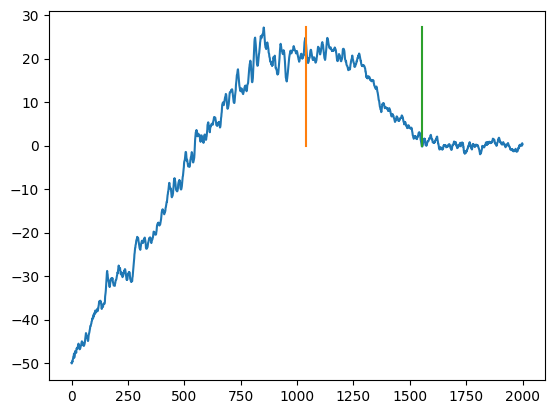

Text(0.5, 0, 'MeV')

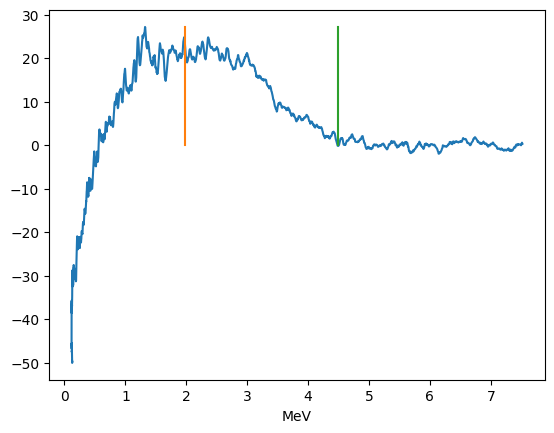

In [27]:
e_dist=df_camera_adjusted.loc[1109]

maxpos=find_max(e_dist)
cutoff_pos=get_cutoff(e_dist,maxpos)

#integrate
print('Integral:',integr(e_dist))

x=np.linspace(0,len(e_dist_adj)-1,len(e_dist_adj))

yaux=np.linspace(0,np.max(e_dist),10)
xaux_max=0*yaux+maxpos
xaux_cutoff=0*yaux+cutoff_pos
plt.plot(e_dist)
plt.plot(xaux_max,yaux)
plt.plot(xaux_cutoff,yaux)
plt.show()

#in energy
x_ene=conv_energy(x)
x_max_ene=conv_energy(xaux_max)
x_cutoff_ene=conv_energy(xaux_cutoff)
plt.plot(x_ene,e_dist)
plt.plot(x_max_ene,yaux)
plt.plot(x_cutoff_ene,yaux)
plt.xlabel('MeV')

## Construct the dataframe with metrics

In [28]:
df_metrics=pd.DataFrame()
df_metrics['Max E']=df_camera_adjusted.apply(find_max,axis=1)
#convert to Energy
df_metrics['Max E']=df_metrics['Max E'].apply(conv_energy)

Error in the find max


/tmp/ipykernel_29417/3993311497.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)


Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max


In [29]:
#calculate hte cutoff energy
df_metrics['Cutoff E']=df_camera_adjusted.apply(get_cutoff_2,axis=1)
#convert to Energy
df_metrics['Cutoff E']=df_metrics['Cutoff E'].apply(conv_energy)

Error in the find max


/tmp/ipykernel_29417/3993311497.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)


Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_29417/3993311497.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_29417/3993311497.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_29417/3993311497.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)


Error in the find max


In [30]:
#calculate the integral
df_metrics['Integr']=df_camera_adjusted.apply(integr,axis=1)

Error in the find max


/tmp/ipykernel_29417/3993311497.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)


Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_29417/3993311497.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_29417/3993311497.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)


Error in the find max


/tmp/ipykernel_29417/3993311497.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)


In [31]:
df_metrics['Integr norm']=df_metrics['Integr'].div(df_input['Laser Energy'])

In [32]:
df_metrics[['Integr','Integr norm']]

,Integr,Integr norm
0,28.510124,12139.094811
1,114.592860,52424.251789
2,25.104442,10759.276519
3,142.009469,62181.694639
4,104.926743,46971.451097
...,...,...
3060,17.804629,7843.829538
3061,51.981119,22067.672085
3062,10.206427,4447.871186
3063,42.334388,18539.717441


Text(0, 0.5, 'Num. shots')

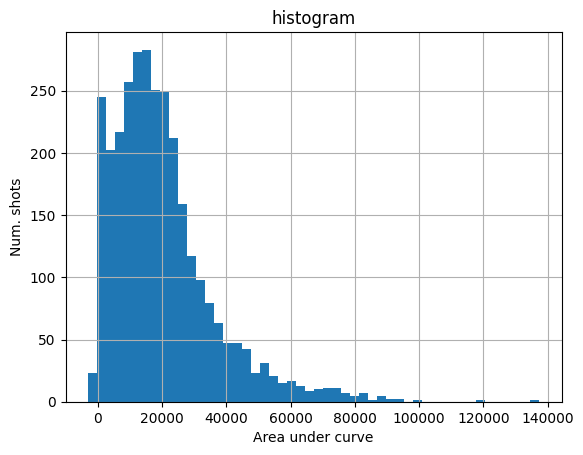

In [33]:
df_metrics['Integr norm'].hist(bins=50)
plt.title('histogram')
plt.xlabel('Area under curve')
plt.ylabel('Num. shots')

Text(0, 0.5, 'Num. shots')

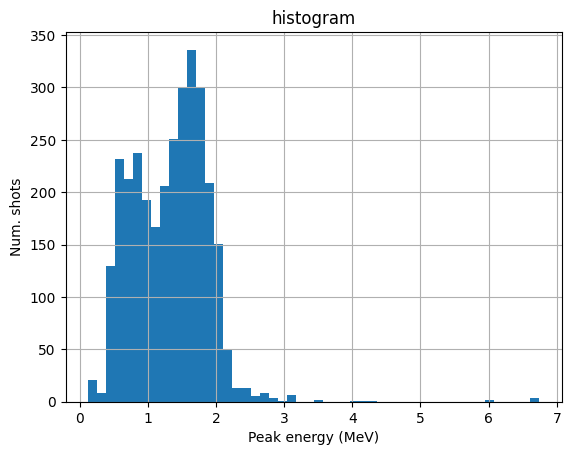

In [34]:
df_metrics['Max E'].hist(bins=50)
plt.title('histogram')
plt.xlabel('Peak energy (MeV)')
plt.ylabel('Num. shots')

### Analyzing the shots with bad energy peak

In [35]:
df_metrics_bad=df_metrics[df_metrics['Max E']<0.6]

bad_shots_list=df_metrics_bad.index.values
#print(good_shots_list)
#remove those wrong points fromt he input list
df_input_bad=df_input.iloc[bad_shots_list]
df_camera_bad=df_camera.iloc[bad_shots_list]

#reset the indexes
df_metrics_bad.reset_index(inplace=True,drop=True)
df_input_bad.reset_index(inplace=True,drop=True)
df_camera_bad.reset_index(inplace=True,drop=True)

In [36]:
df_input_bad

,shot number,order2,order3,order4,Laser Energy
0,129967,35000.0,22000.0,-4600000.0,0.004733
1,129980,34900.0,-2000.0,-3700000.0,0.002457
2,129989,35300.0,-8000.0,-4000000.0,0.002330
3,130002,35400.0,4000.0,-4000000.0,0.002627
4,130040,35400.0,-11000.0,-4000000.0,0.002726
...,...,...,...,...,...
281,132931,35400.0,-11000.0,-3700000.0,0.003020
282,133001,35400.0,-5000.0,-4300000.0,0.002223
283,133014,34900.0,-17000.0,-4300000.0,0.001899
284,133018,35100.0,10000.0,-3700000.0,0.002270


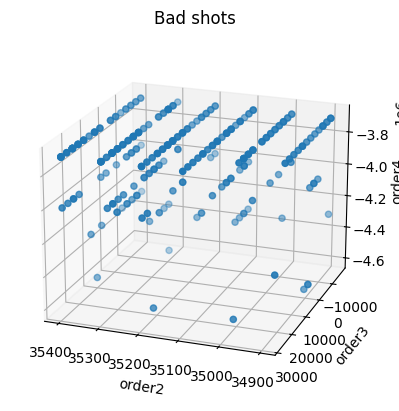

In [37]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(df_input_bad['order2'], df_input_bad['order3'], df_input_bad['order4'])
ax.set_xlabel('order2')
ax.set_ylabel('order3')
ax.set_zlabel('order4')
#zticks = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
#ax.set_zticks(np.log10(zticks))
#print(df_error)
#ax.set_zscale('log')
#ax.set_zlim(-5.5e6,-4e6)
ax.view_init(elev=20., azim=110)
plt.title('Bad shots')
plt.show()

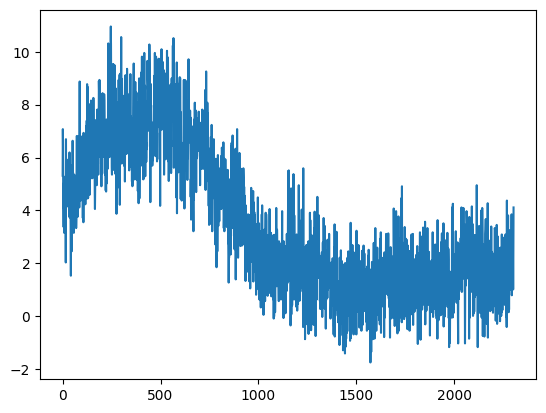

In [38]:
shot_index=51
e_dist=df_camera_bad.loc[shot_index]
shot_numb=df_input_bad['shot number'].loc[shot_index]
plt.plot(e_dist)

## Drop te shots with wrong max E (are the same with wrong integral)

In [39]:
df_metrics_reduced=df_metrics[df_metrics['Max E']>0.5]

good_shots_list=df_metrics_reduced.index.values
#print(good_shots_list)
#remove those wrong points fromt he input list
df_input_reduced=df_input.iloc[good_shots_list]

#reset the indexes
df_metrics_reduced.reset_index(inplace=True,drop=True)
df_input_reduced.reset_index(inplace=True,drop=True)

Text(0, 0.5, 'Num. shots')

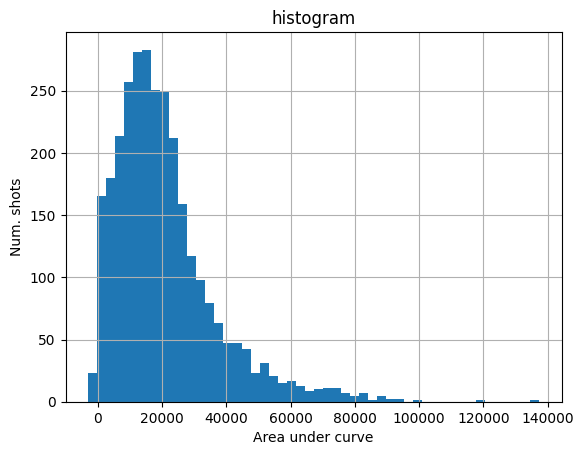

In [40]:
df_metrics_reduced['Integr norm'].hist(bins=50)
plt.title('histogram')
plt.xlabel('Area under curve')
plt.ylabel('Num. shots')

## Average shots

In [41]:
#Average shots with same input param
#NOTE: the 'integ' values are the normalized
def metric_shot_average(df_input,df_metrics):
    emax_list=[]
    ecut_list=[]
    integ_list=[]
    o2_list=[]
    o3_list=[]
    o4_list=[]
    emax_mean=[]
    emax_std=[]
    ecut_mean=[]
    ecut_std=[]
    integ_mean=[]
    integ_std=[]
    integ_mean=[]
    integ_std=[]
    counter=0
    for index,row in df_input.iterrows():
        o2=row['order2']
        o3=row['order3']
        o4=row['order4']
        #print(index)
        if(index==0):
            emax_list.append(df_metrics['Max E'].iloc[index])
            ecut_list.append(df_metrics['Cutoff E'].iloc[index])
            integ_list.append(df_metrics['Integr norm'].iloc[index])
            counter=1
        if(index>0):
            o2_prev=df_input['order2'].iloc[index-1]
            o3_prev=df_input['order3'].iloc[index-1]
            o4_prev=df_input['order4'].iloc[index-1]
            if(o2==o2_prev and o3==o3_prev and o4==o4_prev):
                counter+=1
                emax_list.append(df_metrics['Max E'].iloc[index])
                ecut_list.append(df_metrics['Cutoff E'].iloc[index])
                integ_list.append(df_metrics['Integr norm'].iloc[index])
            else:
                #do the calc
                emax_mean.append(np.mean(emax_list))
                emax_std.append(np.std(emax_list))
                ecut_mean.append(np.mean(ecut_list))
                ecut_std.append(np.std(ecut_list))
                integ_mean.append(np.mean(integ_list))
                integ_std.append(np.std(integ_list))
                o2_list.append(o2_prev)
                o3_list.append(o3_prev)
                o4_list.append(o4_prev)
                #start the new batch
                emax_list=[df_metrics['Max E'].iloc[index]]
                ecut_list=[df_metrics['Cutoff E'].iloc[index]]
                integ_list=[df_metrics['Integr norm'].iloc[index]]
                #print(counter)
                counter=1
            #print(counter)

    df_metrics_avg=pd.DataFrame()
    df_metrics_avg['order2']=o2_list
    df_metrics_avg['order3']=o3_list
    df_metrics_avg['order4']=o4_list
    df_metrics_avg['Emax mean']=emax_mean
    df_metrics_avg['Emax std']=emax_std
    df_metrics_avg['Ecut mean']=ecut_mean
    df_metrics_avg['Ecut std']=ecut_std
    df_metrics_avg['Integr mean']=integ_mean
    df_metrics_avg['Integr std']=integ_std
    return df_metrics_avg

In [42]:
df_metrics_avg=metric_shot_average(df_input_reduced,df_metrics_reduced)

In [43]:
df_metrics_avg

,order2,order3,order4,Emax mean,Emax std,Ecut mean,Ecut std,Integr mean,Integr std
0,34900.0,-17000.0,-4600000.0,0.790614,0.000000,4.454708,0.000000,12139.094811,0.000000
1,35300.0,4000.0,-4300000.0,1.446079,0.354865,5.077743,0.273426,45503.622294,20976.290923
2,35300.0,13000.0,-4000000.0,1.448839,0.349923,5.029541,0.279654,27693.917017,6863.488178
3,35000.0,22000.0,-4600000.0,1.307162,0.421713,4.955855,0.675304,19194.164700,8988.351676
4,34900.0,-2000.0,-3700000.0,1.559431,0.198472,4.900242,0.349146,19052.103958,10853.983213
...,...,...,...,...,...,...,...,...,...
379,35300.0,-11000.0,-4000000.0,1.824403,0.948095,3.448395,0.773121,5345.278516,5704.075104
380,35100.0,28000.0,-4000000.0,1.933937,0.171902,4.668890,0.422864,14448.255645,6597.774549
381,34900.0,-8000.0,-4300000.0,1.257281,0.338610,4.314855,0.486059,32557.257546,14499.264118
382,35400.0,-5000.0,-4300000.0,1.152782,0.676457,3.055702,1.459980,20886.154592,28329.953068


In [44]:
print(df_metrics_avg[df_metrics_avg['Integr mean']>30000])

      order2   order3     order4  Emax mean  Emax std  Ecut mean  Ecut std  \
1    35300.0   4000.0 -4300000.0   1.446079  0.354865   5.077743  0.273426   
9    35300.0  -5000.0 -4600000.0   1.164265  0.348530   4.688149  0.417621   
17   35300.0  19000.0 -4000000.0   1.313932  0.274578   4.872181  0.505557   
29   35400.0  10000.0 -4300000.0   1.154304  0.212182   4.964527  0.471615   
31   35200.0  10000.0 -4300000.0   1.349212  0.361911   5.000892  0.565404   
48   35200.0   1000.0 -4300000.0   1.154002  0.366985   4.558695  0.738129   
53   35400.0   4000.0 -4600000.0   1.199259  0.450752   4.719520  0.516799   
67   35200.0  -8000.0 -4600000.0   1.254193  0.483543   4.542027  0.458247   
70   35300.0  10000.0 -4000000.0   1.207328  0.384894   4.396877  0.865485   
104  35200.0 -11000.0 -4600000.0   1.131922  0.274559   4.560416  0.621640   
130  35300.0  16000.0 -4000000.0   1.320882  0.332665   4.430850  0.671718   
136  35300.0  -8000.0 -4600000.0   1.415305  0.319946   4.476782

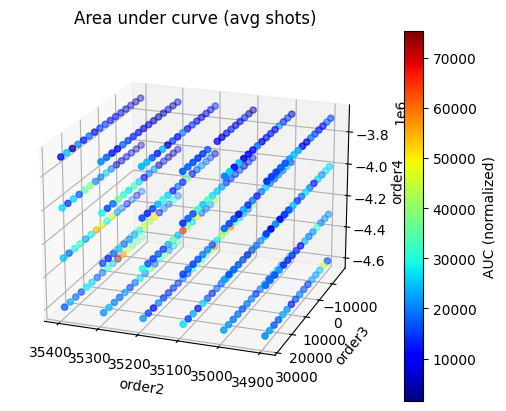

In [45]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
plot_3d=ax.scatter(df_metrics_avg['order2'], df_metrics_avg['order3'], df_metrics_avg['order4'],c=df_metrics_avg['Integr mean'],cmap='jet')
ax.set_xlabel('order2')
ax.set_ylabel('order3')
ax.set_zlabel('order4')
#zticks = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
#ax.set_zticks(np.log10(zticks))
#print(df_error)
#ax.set_zscale('log')
#ax.set_zlim(-5.5e6,-4e6)
ax.view_init(elev=20., azim=110)
plt.title('Area under curve (avg shots)')
cbar =fig.colorbar(plot_3d,ax=ax)
cbar.set_label('AUC (normalized)')
plt.show()

### Comparison with Austin's calculation

In [46]:
#df_metrics
#df_input
#take the shots that
df_input_comp=df_input[(df_input['shot number']>131056) & (df_input['shot number']<131078)]

comp_shots_list=df_input_comp.index.values
#print(good_shots_list)
#take these shots only
df_metrics_comp=df_metrics.iloc[comp_shots_list]
df_camera_comp=df_camera_adjusted.iloc[comp_shots_list]

#reset the indexes
df_metrics_comp.reset_index(inplace=True,drop=True)
df_input_comp.reset_index(inplace=True,drop=True)
df_camera_comp.reset_index(inplace=True,drop=True)

In [47]:
df_input_comp

,shot number,order2,order3,order4,Laser Energy
0,131057,35200.0,16000.0,-4300000.0,0.003429
1,131058,35200.0,16000.0,-4300000.0,0.003513
2,131059,35200.0,16000.0,-4300000.0,0.003605
3,131060,35200.0,16000.0,-4300000.0,0.003432
4,131061,35200.0,16000.0,-4300000.0,0.003452
5,131062,35000.0,-14000.0,-4300000.0,0.002111
6,131063,35000.0,-14000.0,-4300000.0,0.001985
7,131064,35000.0,-14000.0,-4300000.0,0.002139
8,131065,35000.0,-14000.0,-4300000.0,0.002121
9,131066,35000.0,-14000.0,-4300000.0,0.002005


In [48]:
austin_shots=(20067,14068,30356,11761,14915,32670,30328,17118,26090,8185,
              9927,18080,9846,14490,17803,19674,12723,13707,479,17194,12180)

In [49]:
integ_count_comp=df_camera_comp[df_camera_comp>0].sum(axis=1)

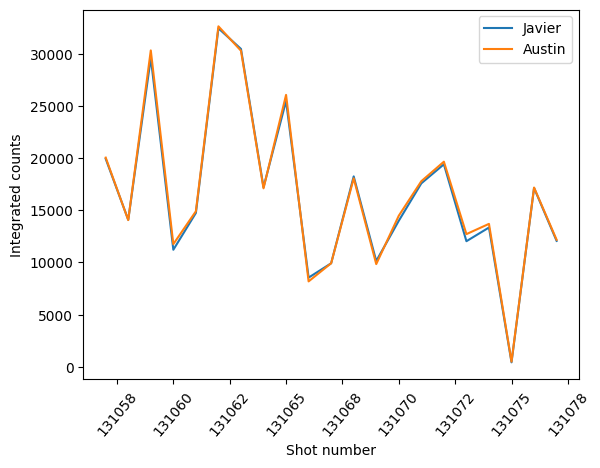

In [50]:
fig, ax = plt.subplots()
#plt.plot(df_input_comp['shot number'],df_metrics_comp['Integr'],label='Javier')
plt.plot(df_input_comp['shot number'],integ_count_comp,label='Javier')
plt.plot(df_input_comp['shot number'],austin_shots,label='Austin')
plt.xlabel('Shot number')
plt.ylabel('Integrated counts')
#plt.yscale('log')
plt.legend()
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
ax.tick_params(axis='x', labelrotation=50)
plt.show()

In [51]:
df_metrics_comp['Integr']

0      46.666832
1      47.745596
2      97.280238
3      43.438808
4      56.477617
5     101.261391
6      96.320125
7      40.543116
8      69.009614
9      28.952622
10     21.386328
11     40.277104
12     27.575296
13     51.204190
14     62.298783
15     72.720884
16     46.220110
17     47.168900
18      0.477993
19     67.184887
20     45.844735
Name: Integr, dtype: float64

CAREFUL!!!!----, hard coded the number
Area under curve= 56.477617443235886
629.2496149362705


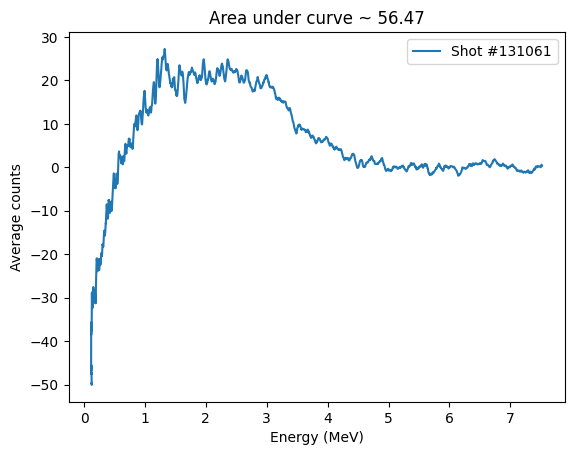

In [52]:
#locate the index of the first test shot
#temp_loc=df_input[df_input['shot number']==131057].index.values
temp_loc=df_input[df_input['shot number']==131061].index.values
e_dist=df_camera_adjusted.loc[temp_loc].values[0]

print('CAREFUL!!!!----, hard coded the number')
print('Area under curve=',df_metrics_comp['Integr'].loc[4])
print(e_dist.sum())
x=np.linspace(0,len(e_dist)-1,len(e_dist))
x_ene=conv_energy(x)
plt.plot(x_ene,e_dist,label='Shot #131061')
plt.xlabel('Energy (MeV)')
plt.ylabel('Average counts')
plt.title('Area under curve ~ 56.47')
plt.legend()

In [53]:
df_metrics_comp['Integr'].values

array([ 46.66683228,  47.74559618,  97.28023843,  43.43880762,
        56.47761744, 101.26139072,  96.32012491,  40.54311643,
        69.00961357,  28.95262225,  21.38632755,  40.27710367,
        27.57529568,  51.20419033,  62.29878339,  72.72088444,
        46.22011002,  47.16890014,   0.47799332,  67.18488673,
        45.84473532])

In [54]:
df_metrics_comp['Integr norm'].values

array([13610.80626012, 13592.35502241, 26985.6757374 , 12658.7417808 ,
       16361.32959427, 47966.10006875, 48514.69997902, 18950.4815263 ,
       32531.95360076, 14443.54172479, 10285.10953855, 19874.78553258,
       12898.1115797 , 15589.58340016, 19085.98167863, 23191.99912647,
       14658.03269263, 14369.37571642,   143.99866567, 20468.42838687,
       14092.2810222 ])

In [55]:
austin_integr= (46.36657459078529,  47.523136225004734,  96.89437401863586,  43.35115768393256,  56.36809950654694,  101.00955004536948,  96.08730288787358,  40.33473928446608,  68.81432760241813,  28.875225324038155,  21.233215861658778,  40.04925027091488,  27.439095325673073,  50.96117057144616,  62.21077252012856,  72.53312707144511,  46.1855596689928,  46.967046312958885,  -0.47725679179952696,  67.07540920974019,  45.5810520154873)

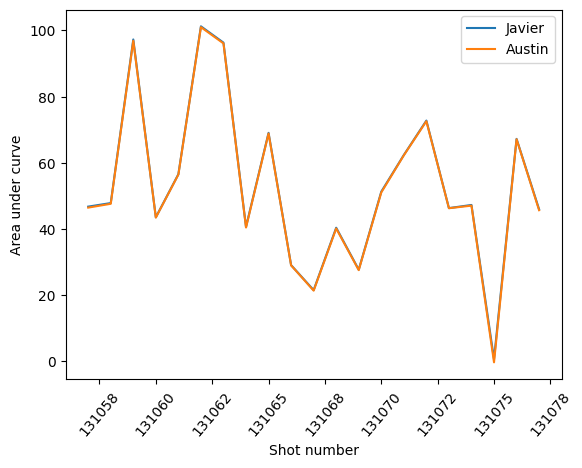

In [56]:
fig, ax = plt.subplots()
#plt.plot(df_input_comp['shot number'],df_metrics_comp['Integr'],label='Javier')
plt.plot(df_input_comp['shot number'],df_metrics_comp['Integr'],label='Javier')
plt.plot(df_input_comp['shot number'],austin_integr,label='Austin')
plt.xlabel('Shot number')
plt.ylabel('Area under curve')
#plt.yscale('log')
plt.legend()
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
ax.tick_params(axis='x', labelrotation=50)
plt.show()

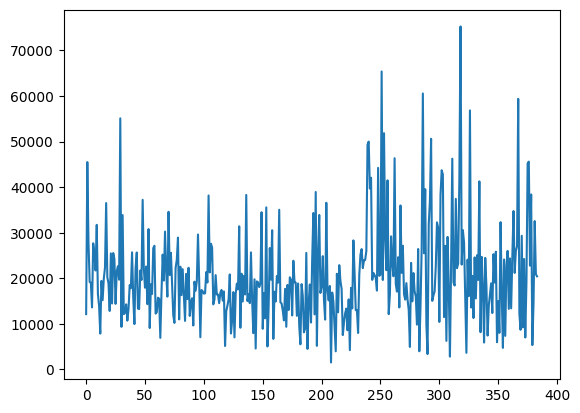

In [57]:
plt.plot(df_metrics_avg['Integr mean'].values)

### Analysis on different region of interest

(1200.0, 0.0)

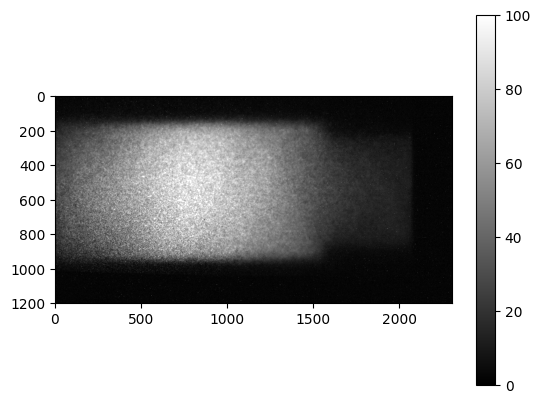

In [58]:
plt.imshow(camera_clean[1],cmap='gray',vmin=0,vmax=100)
plt.colorbar(orientation='vertical')
plt.ylim(1200,0)

In [59]:
def avg_1d(camera_array,minval,maxval):
    camera_red=camera_array[minval:maxval,:]
    camera_1d=np.average(camera_red[:,:],axis=0)
    return camera_1d

In [60]:
#minval=500
#maxval=550
camera_1d_1=avg_1d(camera_clean[3],minval=500,maxval=550)
camera_1d_2=avg_1d(camera_clean[3],minval=400,maxval=800)

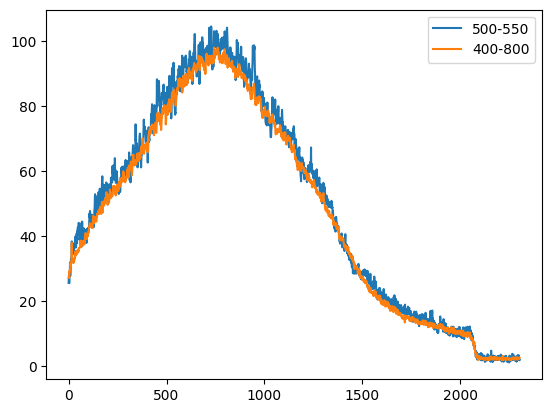

In [61]:
plt.plot(camera_1d_1,label='500-550')
plt.plot(camera_1d_2,label='400-800')
#plt.yscale('log')
plt.legend()

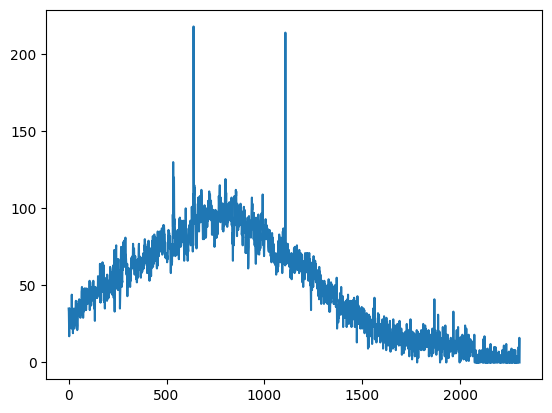

In [62]:
plt.plot(camera_clean[3][400,:])

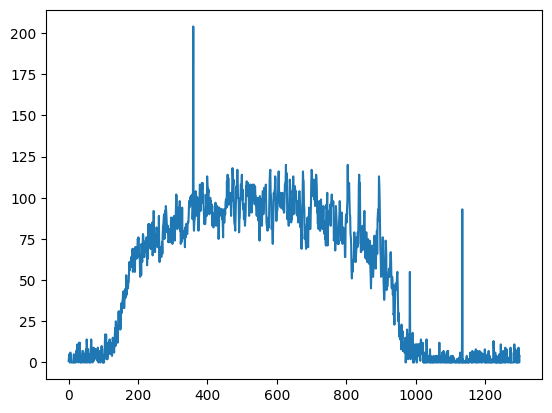

In [63]:
plt.plot(camera_clean[3][:,800])